# <center><b>川渝地区新中式茶饮消费现状与意愿调查</b></center>

## 提前导入库

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib
import warnings

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# 忽略无关警告
warnings.filterwarnings('ignore')

# 图像可以显示中文
matplotlib.rcParams['font.sans-serif'] = ['STSong']
matplotlib.rcParams['axes.unicode_minus'] = False

# 设置，使得数据对齐
pd.set_option('display.max_rows', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)

# 设置随机种子
np.random.seed(114514)

## 1. 数据读取与探索性分析

In [11]:
raw_data = pd.read_excel('resources/2新中式茶饮消费现状与意愿调查.xlsx') # 原始数据

data_filter = raw_data.iloc[:,1:-2] # 排除掉 序号 | 词云数据

# 量表数据
tableData = data_filter.iloc[:,15:42]

In [6]:
data_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 66 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   您的性别：                                             101 non-null    object
 1   您的年龄：                                             101 non-null    object
 2   您的职业：                                             101 non-null    object
 3   您的学历：                                             101 non-null    object
 4   您的月收入：                                            101 non-null    object
 5   请选择省份城市与地区:                                       101 non-null    object
 6   您一个月喝茶饮的频率是？                                      101 non-null    object
 7   您习惯的茶饮购买渠道是？                                      101 non-null    object
 8   您希望以哪种形式享用茶饮？                                     101 non-null    object
 9   以下茶饮分类中，目前您更偏向于喝哪种？             

In [7]:
tableData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   产品质量—口味                  101 non-null    int64
 1   口感                       101 non-null    int64
 2   原料健康程度                   101 non-null    int64
 3   特色度                      101 non-null    int64
 4   附属产品—包装精美                101 non-null    int64
 5   容器质量                     101 non-null    int64
 6   赠品迷人                     101 non-null    int64
 7   价格因素—价格合理                101 non-null    int64
 8   促销力度                     101 non-null    int64
 9   性价比高                     101 non-null    int64
 10  服务—店员服务态度                101 non-null    int64
 11  平台服务                     101 non-null    int64
 12  产品介绍和推荐                  101 non-null    int64
 13  点单指导                     101 non-null    int64
 14  门店环境                     101 non-null    int64
 15  消费者偏好—

这个数据集是完整的，没有缺失值，包含了105条记录和49个整数类型的特征，现在可以进行后续的数据分析或机器学习处理。

## 2. 信效度检验

In [8]:
# 信度检验------计算Cronbach's 系数
result = pg.cronbach_alpha(data=tableData)
print(result)

(0.8697126969645885, array([0.83 , 0.904]))


由此计算结果得出结论，Cronbach's 系数的值为0.870，该结果可以说明该问卷是可信的或具有可靠性的

In [9]:
# 效度检验------Barlett's球形检验
chi_square_value, p_value = calculate_bartlett_sphericity(tableData)
print("bartlett球形检验参数：\n卡方值为：%f，p值为：%e"%(chi_square_value, p_value))

# 效度检验------KMO
kmo_all, kmo_model = calculate_kmo(tableData)
print("KMO检验参数：\n", kmo_model)


bartlett球形检验参数：
卡方值为：1332.798286，p值为：3.393312e-114
KMO检验参数：
 0.7462515069595392


bartlett球形检验的p值小于0.05，检验通过，说明原变量之间存在相关性，另外KMO统计量为0.746，变量相关性很强

## 3. K-means 聚类分析

In [15]:
WCSS = [] # 簇内平方和
Ya_data = pd.get_dummies(data_filter, drop_first=True, dtype=int)
for i in range(2, 11): # 从2到10中选择
    km = KMeans(n_clusters=i, n_init='auto', random_state=0, algorithm='elkan').fit(Ya_data)
    WCSS.append(km.inertia_) # inertia_: 簇内平方和

WCSS

[2983.9244131455403,
 2872.7192982456145,
 2721.8474710638966,
 2657.918768115942,
 2578.484523809524,
 2508.4575702075704,
 2366.448773448774,
 2341.6258626177746,
 2262.8831654456653]

Text(0, 0.5, 'Inertia')

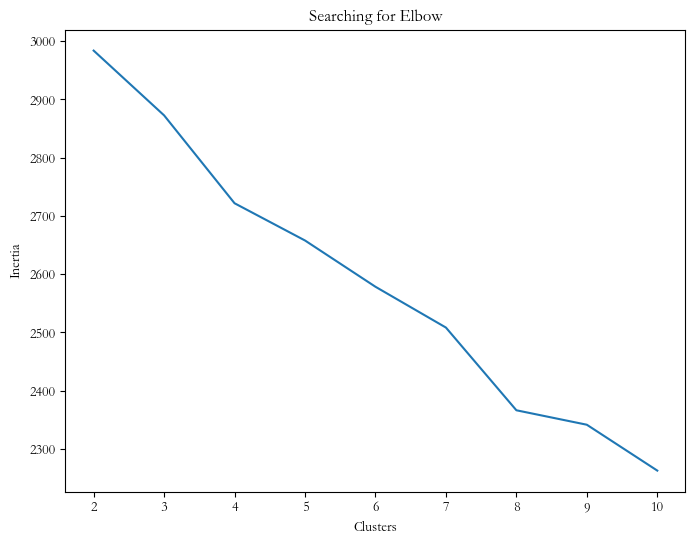

In [17]:
x_idx = np.arange(2, 11)
Y = np.array(WCSS)
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(x_idx, Y)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')


根据K-means聚类分析的结果，受众人群分为8类较为合适

## 4.决策树与随机森林

In [24]:
# 获取目标值
y_list = raw_data.iloc[:, -1].to_list()
y_data = []
for i in range(len(y_list)):
    temp = 1 if y_list[i] >= 100 else 0
    y_data.append(temp)
y_dataFrame = pd.DataFrame()
y_dataFrame["y"] = y_data

# 合并数据集
data = pd.concat([Ya_data, y_dataFrame], axis=1)
X, y = data.iloc[:, :-1], data.iloc[:, -1]

# 划分测试集和训练集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


### 4.1.决策树

In [27]:
clf_prune = DecisionTreeClassifier(ccp_alpha = 0.05)
clf_prune.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.05)

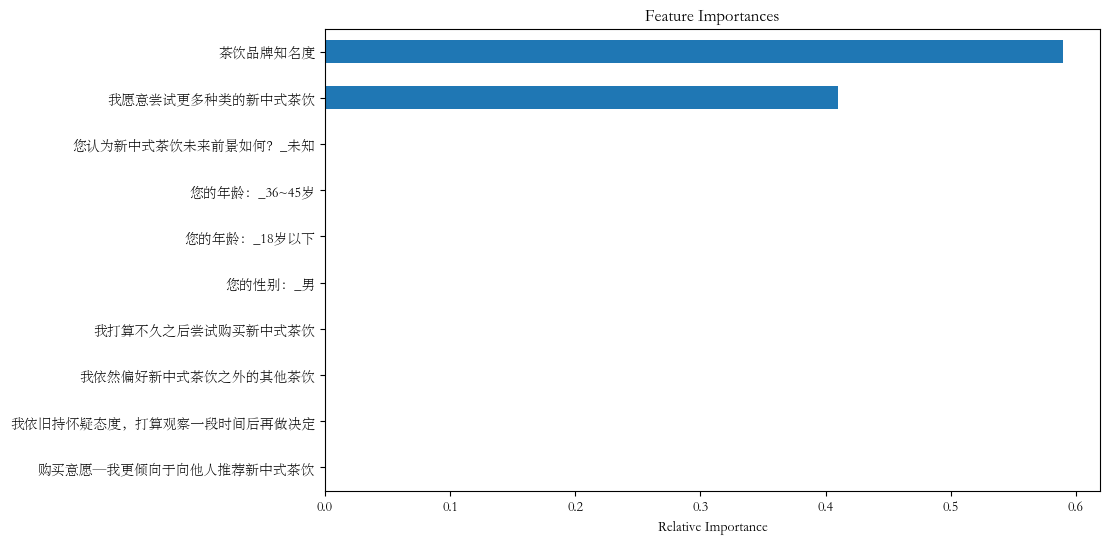

In [30]:
importances = clf_prune.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
weights.sort_values()[-10:].plot(kind = 'barh')
plt.xlabel('Relative Importance')
plt.show()

### 4.2.随机森林

In [25]:
model_rf = RandomForestClassifier(n_estimators=100 , oob_score = True, 
                                  random_state =50, max_features = "sqrt")

# 在训练集上训练
model_rf.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=50)

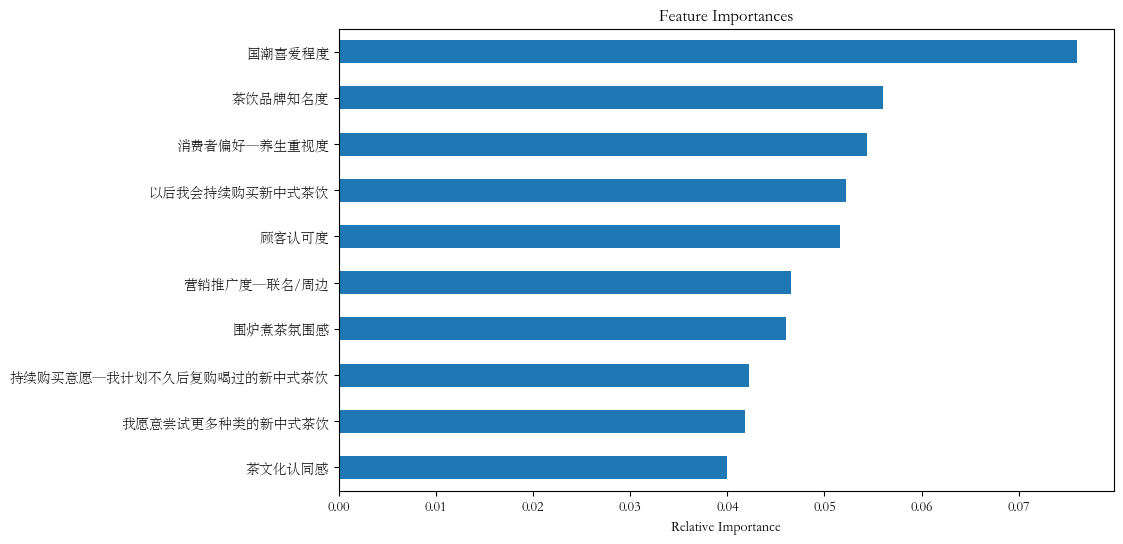

In [26]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
weights.sort_values()[-10:].plot(kind = 'barh')
plt.xlabel('Relative Importance')
plt.show()

### 5.Amos Graghics

#### 5.1.选择关键变量

从选择关键变量开始，然后进行初步的探索性数据分析（EDA）。让我们首先关注一些核心变量，比如性别、年龄、职业、学历、月收入、消费频率和购买渠道，然后检查这些变量与消费者对新中式茶饮看法之间的关系。

In [31]:
column_names = raw_data.columns
column_names

Index(['序号', '您的性别：', '您的年龄：', '您的职业：', '您的学历：',
       '您的月收入：', '请选择省份城市与地区:', '您一个月喝茶饮的频率是？',
       '您习惯的茶饮购买渠道是？', '您希望以哪种形式享用茶饮？',
       '以下茶饮分类中，目前您更偏向于喝哪种？', '您更喜欢哪种口味的茶饮？',
       '您喜欢的包装风格是', '您最喜欢的茶饮促销方式是？',
       '您喝过新中式茶饮（如霸王茶姬、茶颜悦色、茶话弄、tea’stone、椿风、沏茶师、去茶山等）吗？',
       '您购买新中式茶饮的原因是？', '产品质量—口味', '口感', '原料健康程度',
       '特色度', '附属产品—包装精美', '容器质量', '赠品迷人',
       '价格因素—价格合理', '促销力度', '性价比高', '服务—店员服务态度',
       '平台服务', '产品介绍和推荐', '点单指导', '门店环境',
       '消费者偏好—养生重视度', '国潮喜爱程度', '茶文化认同感',
       '茶饮名称好听', '围炉煮茶氛围感', '营销推广度—联名/周边',
       '茶饮品牌知名度', '产品曝光度', '顾客认可度',
       '持续购买意愿—我计划不久后复购喝过的新中式茶饮',
       '以后我会持续购买新中式茶饮', '我愿意尝试更多种类的新中式茶饮',
       '价格劣势—新中式茶饮相对其他茶饮价格较高', '新中式茶饮性价比较低',
       '新中式茶饮价格不合理', '认知程度—我不了解新中式茶饮的原材料',
       '我不清楚新中式茶饮的优点', '我不知道新中式茶饮的价格行情',
       '感知风险—担心新中式茶饮口味质量不佳',
       '担心新中式茶饮会使自身变胖，违背瘦身意愿',
       '担心新中式茶饮无合法营业执照、不卫生',
       '评论的无效性—评论列表中负面评论日期越近，越不会轻易尝试购买新中式茶饮',
       '评论列表中负面评论越靠前，我越认为新中式茶饮差',
       '产品评论中负面评论越集中，越容易对新中式茶饮印象差',
    

In [33]:
# Correcting variable names based on the dataset's column names for EDA
corrected_variables_for_eda = {
    '性别': '您的性别：',
    '年龄': '您的年龄：',
    '职业': '您的职业：',
    '学历': '您的学历：',
    '月收入': '您的月收入：',
    '消费频率': '您一个月喝茶饮的频率是？',
    '购买渠道': '您习惯的茶饮购买渠道是？'
}

# Redoing the EDA with correct variable names
eda_summary_corrected = raw_data[list(corrected_variables_for_eda.values())].describe(include='all')

eda_summary_corrected


,您的性别：,您的年龄：,您的职业：,您的学历：,您的月收入：,您一个月喝茶饮的频率是？,您习惯的茶饮购买渠道是？
count,101,101,101,101,101,101,101
unique,2,5,7,5,4,5,4
top,男,18~25岁,普通职员,大专,5001~10000元,经常，几乎每周都喝，一个月5~10次,门店购买
freq,53,43,56,43,45,55,44


从初步的探索性数据分析（EDA）中，我们可以观察到以下关键点：

- 性别：参与者中男性（53人）略多于女性。
- 年龄：大多数参与者（43人）处于18~25岁年龄段。
- 职业：普通职员是最常见的职业（56人）。
- 学历：大专学历的参与者最多（43人）。
- 月收入：5001~10000元是最常见的月收入区间（45人）。
- 消费频率：绝大多数参与者表示“经常，几乎每周都喝，一个月5~10次”（55人）。
- 购买渠道：门店购买是最习惯的购买渠道（44人）。

这些信息为我们提供了一个关于新中式茶饮消费者特征的概览。年轻的、普通职员、有一定教育背景和中等收入水平的人群似乎是新中式茶饮的主要消费者。他们倾向于频繁消费，并且更喜欢在门店购买。

接下来，我们可以基于这些信息，进一步探索哪些因素影响消费者对新中式茶饮的看法，例如通过查看消费频率与其他变量之间的关系，或者分析不同年龄段和收入水平的消费者对茶饮的偏好差异。我们可以使用相关性分析或构建一些简单的预测模型来探索这些变量之间的关系。

In [39]:
# Mapping categorical variables to numerical values for correlation analysis
# This includes converting variables like gender, occupation, education, monthly income, and purchase channel into numerical formats

# Assuming the raw_dataset uses categorical labels for these variables, we will map them to numerical values
# For simplicity, I'll show an example mapping for gender and apply similar mappings to other variables if needed

# Example mappings
gender_mapping = {'男': 1, '女': 0}
occupation_mapping = {occupation: index for index, occupation in enumerate(raw_data['您的职业：'].unique())}
education_mapping = {education: index for index, education in enumerate(raw_data['您的学历：'].unique())}
income_mapping = {income: index for index, income in enumerate(raw_data['您的月收入：'].unique())}
frequency_mapping = {frequency: index for index, frequency in enumerate(raw_data['您一个月喝茶饮的频率是？'].unique())}
channel_mapping = {channel: index for index, channel in enumerate(raw_data['您习惯的茶饮购买渠道是？'].unique())}

# Applying mappings
raw_data_mapped = raw_data.copy()
raw_data_mapped['您的性别：'] = raw_data['您的性别：'].map(gender_mapping)
raw_data_mapped['您的职业：'] = raw_data['您的职业：'].map(occupation_mapping)
raw_data_mapped['您的学历：'] = raw_data['您的学历：'].map(education_mapping)
raw_data_mapped['您的月收入：'] = raw_data['您的月收入：'].map(income_mapping)
raw_data_mapped['您一个月喝茶饮的频率是？'] = raw_data['您一个月喝茶饮的频率是？'].map(frequency_mapping)
raw_data_mapped['您习惯的茶饮购买渠道是？'] = raw_data['您习惯的茶饮购买渠道是？'].map(channel_mapping)

Ya_raw_data = pd.get_dummies(raw_data_mapped, drop_first=True, dtype=int)

correlation_with_frequency = Ya_raw_data.corrwith(Ya_raw_data['您一个月喝茶饮的频率是？'])
correlation_with_frequency

序号                                                                          -0.095562
您的性别：                                                                     0.125411
您的职业：                                                                    -0.010633
您的学历：                                                                    -0.116146
您的月收入：                                                                   0.057994
您一个月喝茶饮的频率是？                                                       1.000000
您习惯的茶饮购买渠道是？                                                      -0.013596
产品质量—口味                                                                 0.087302
口感                                                                           0.072847
原料健康程度                                                                   0.158267
特色度                                                                         0.000645
附属产品—包装精美                                                            -0.188653
容器质量              

根据相关性分析的结果，我们可以看到各因素与消费频率之间的相关性大小如下：

- 您的性别：0.125411，说明性别与消费频率之间的相关性较弱，且略微倾向于女性消费频率稍高。
- 您的职业：-0.010633，职业与消费频率的相关性也较弱，表明不同职业群体在消费频率上的差异不大。
- 您的学历：-0.116146，显示学历与消费频率几乎没有相关性。
- 您的月收入：0.057994，月收入与消费频率的相关性相对更明显，暗示月收入较高的消费者可能会有更高的消费频率。
- 您习惯的茶饮购买渠道：-0.013596，表明购买渠道与消费频率有一定的负相关性，可能反映了不同购买渠道的便利性和消费者偏好。

这些结果提示我们，月收入可能是影响消费频率的一个重要因素，而购买渠道的选择也反映了消费者的某些消费习惯和偏好。性别、职业和学历对消费频率的影响相对较小。

In [40]:
# 分析受访者最常用的茶饮购买渠道
channel_counts = raw_data['您习惯的茶饮购买渠道是？'].value_counts()
channel_counts


您习惯的茶饮购买渠道是？
门店购买       44
外卖app下单    43
小程序购买     11
其他            3
Name: count, dtype: int64

受访者最常用的茶饮购买渠道是「门店购买」和「外卖app下单」，这两个渠道的使用人数非常接近，分别为44人和43人。此外，「小程序购买」也有一定的使用者，共11人。还有3人选择了「其他」作为他们的购买渠道。

这表明虽然线上购买方式（如外卖app和小程序）在现代消费中变得越来越流行，但传统的门店购买方式仍然保持着重要的地位。这可能反映了消费者在购买茶饮时既追求便利性也重视体验感。

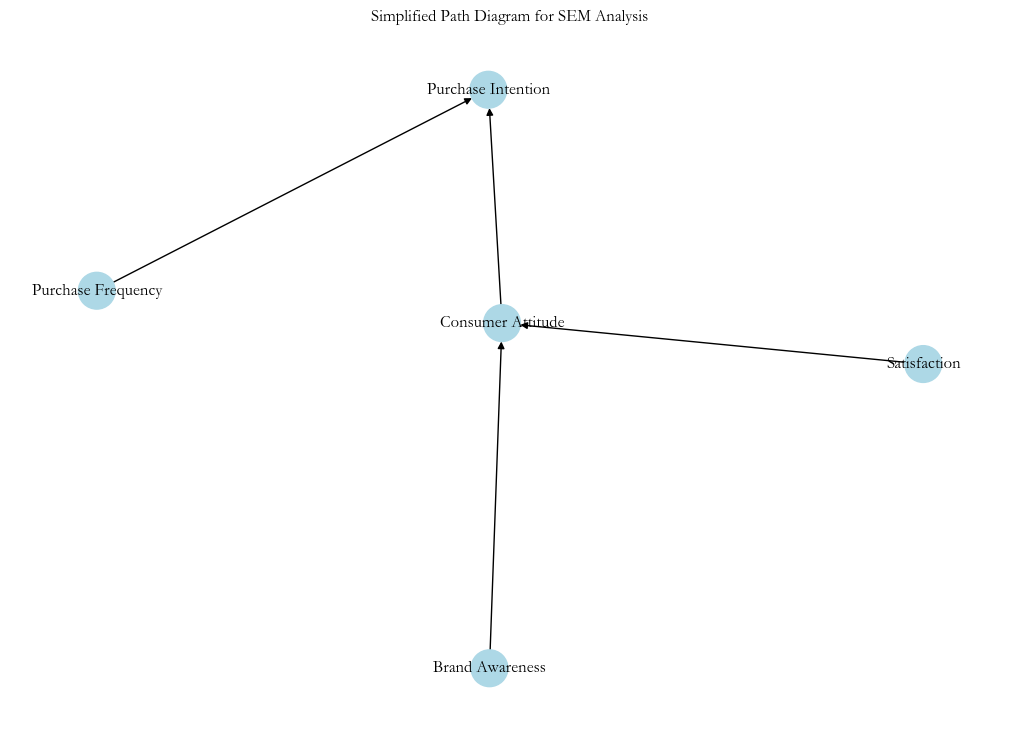

In [42]:

# 创建一个有向图
G = nx.DiGraph()

# 添加节点
G.add_node("Consumer Attitude", node_color='lightblue')
G.add_node("Purchase Intention", node_color='lightgreen')
G.add_node("Brand Awareness", node_color='lightcoral')
G.add_node("Satisfaction", node_color='lightgrey')
G.add_node("Purchase Frequency", node_color='lightgrey')

# 添加边来表示变量之间的关系
G.add_edges_from([
    ("Consumer Attitude", "Purchase Intention"),
    ("Brand Awareness", "Consumer Attitude"),
    ("Satisfaction", "Consumer Attitude"),
    ("Purchase Frequency", "Purchase Intention")
])

# 图形布局
pos = nx.spring_layout(G)

# 节点大小
sizes = [700 for _ in range(len(G.nodes()))]

# 绘制图形
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_size=sizes, node_color="lightblue", font_size=12, arrows=True)

# 显示图形
plt.title("Simplified Path Diagram for SEM Analysis")
plt.show()


根据这个图形的结果可以发现
- 「消费者态度」受到「品牌认知」和「满意度」的影响
- 「购买意愿」则受到「消费者态度」和「购买频率」的影响